# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
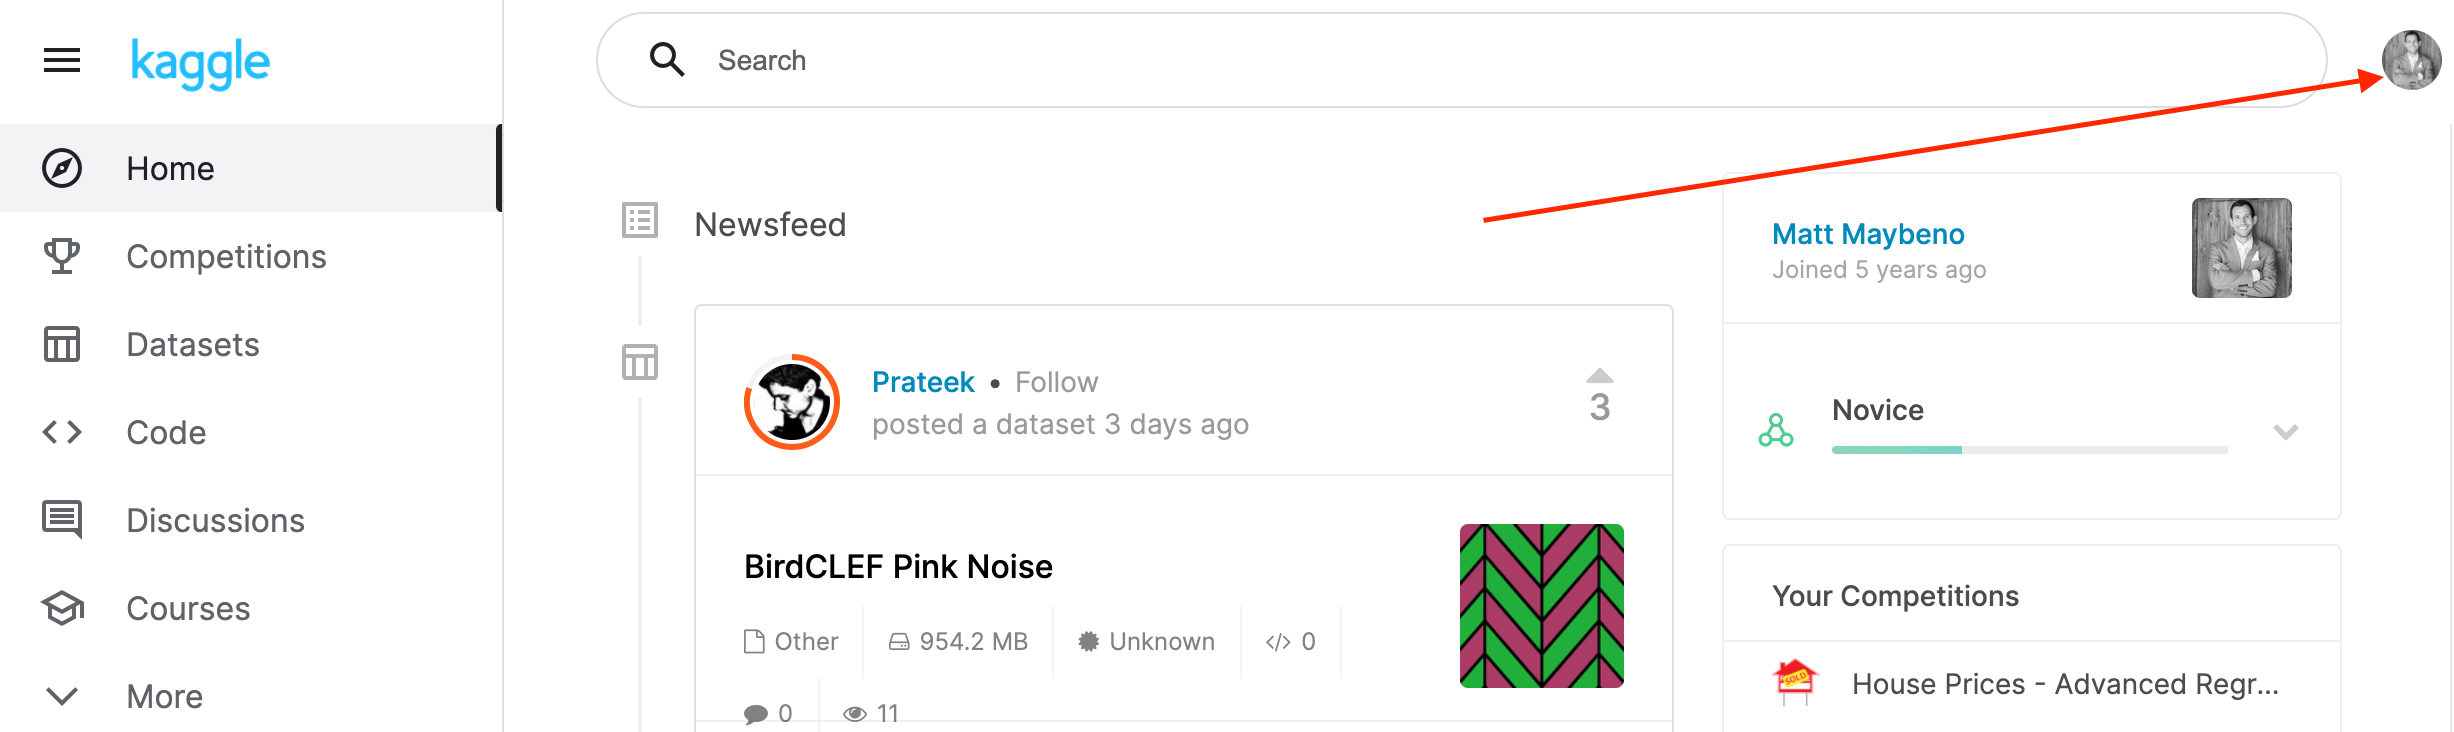
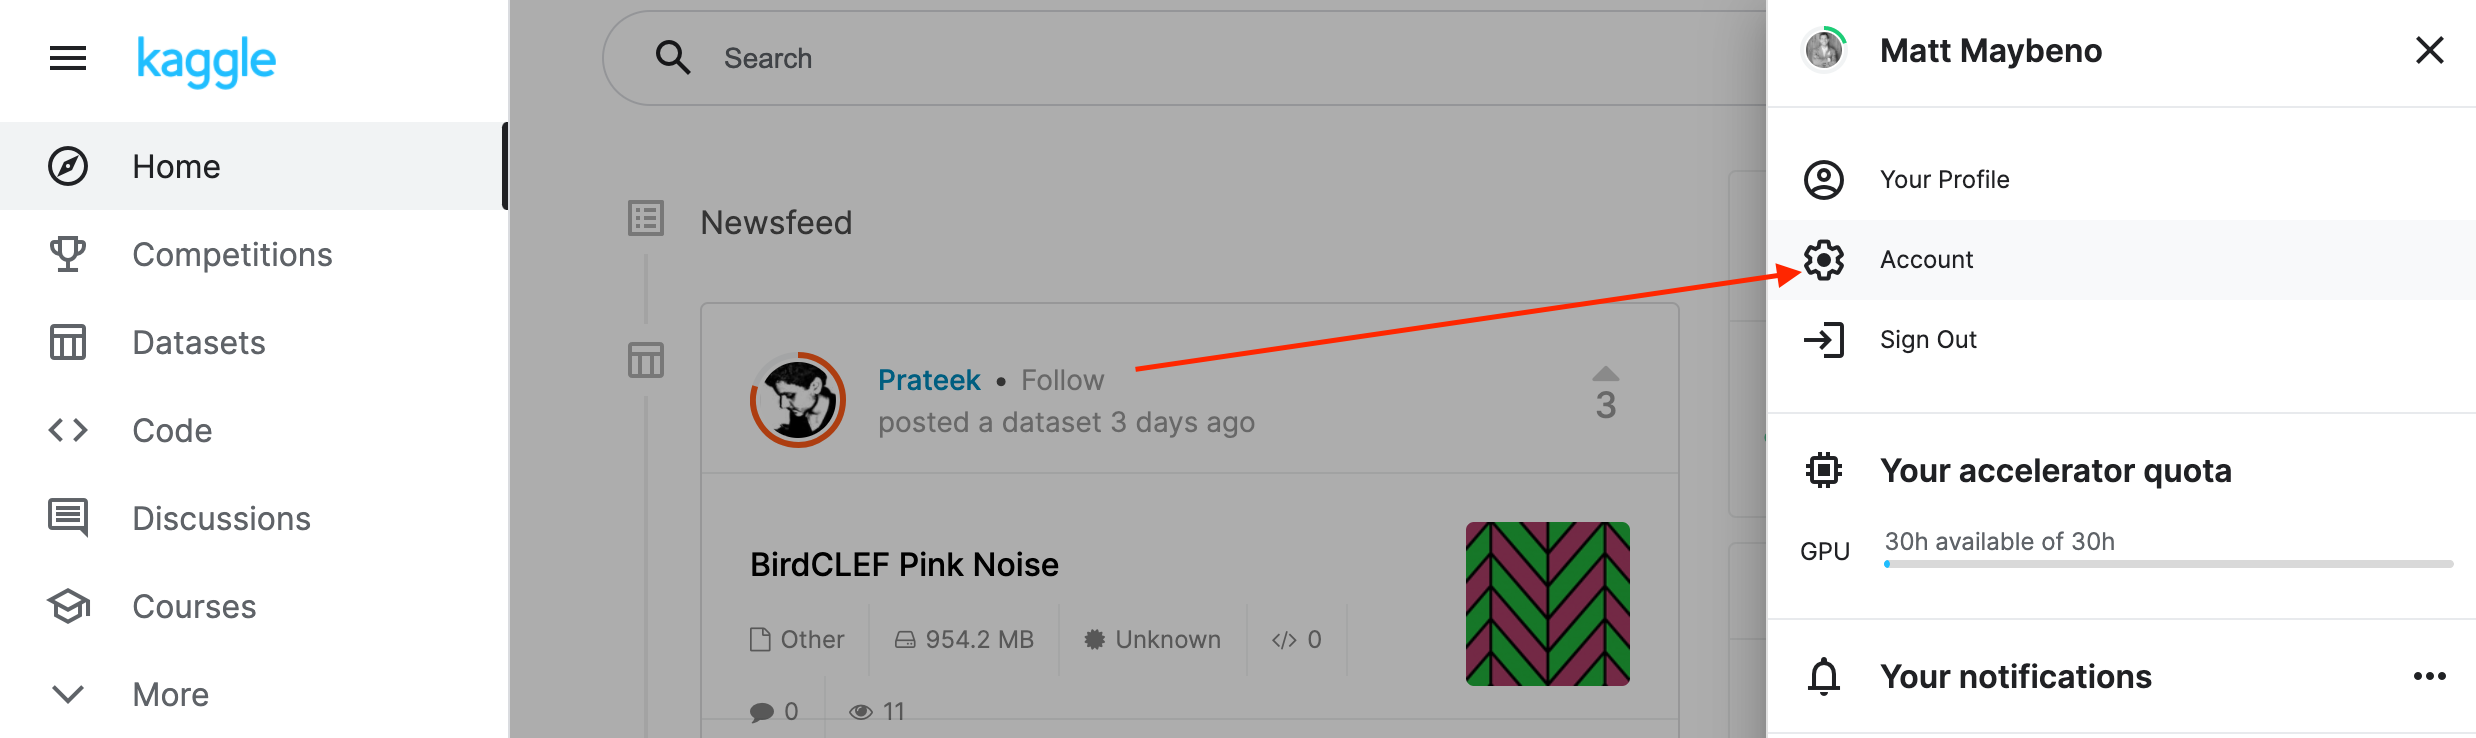
2. Scroll down to API and click Create New API Token.
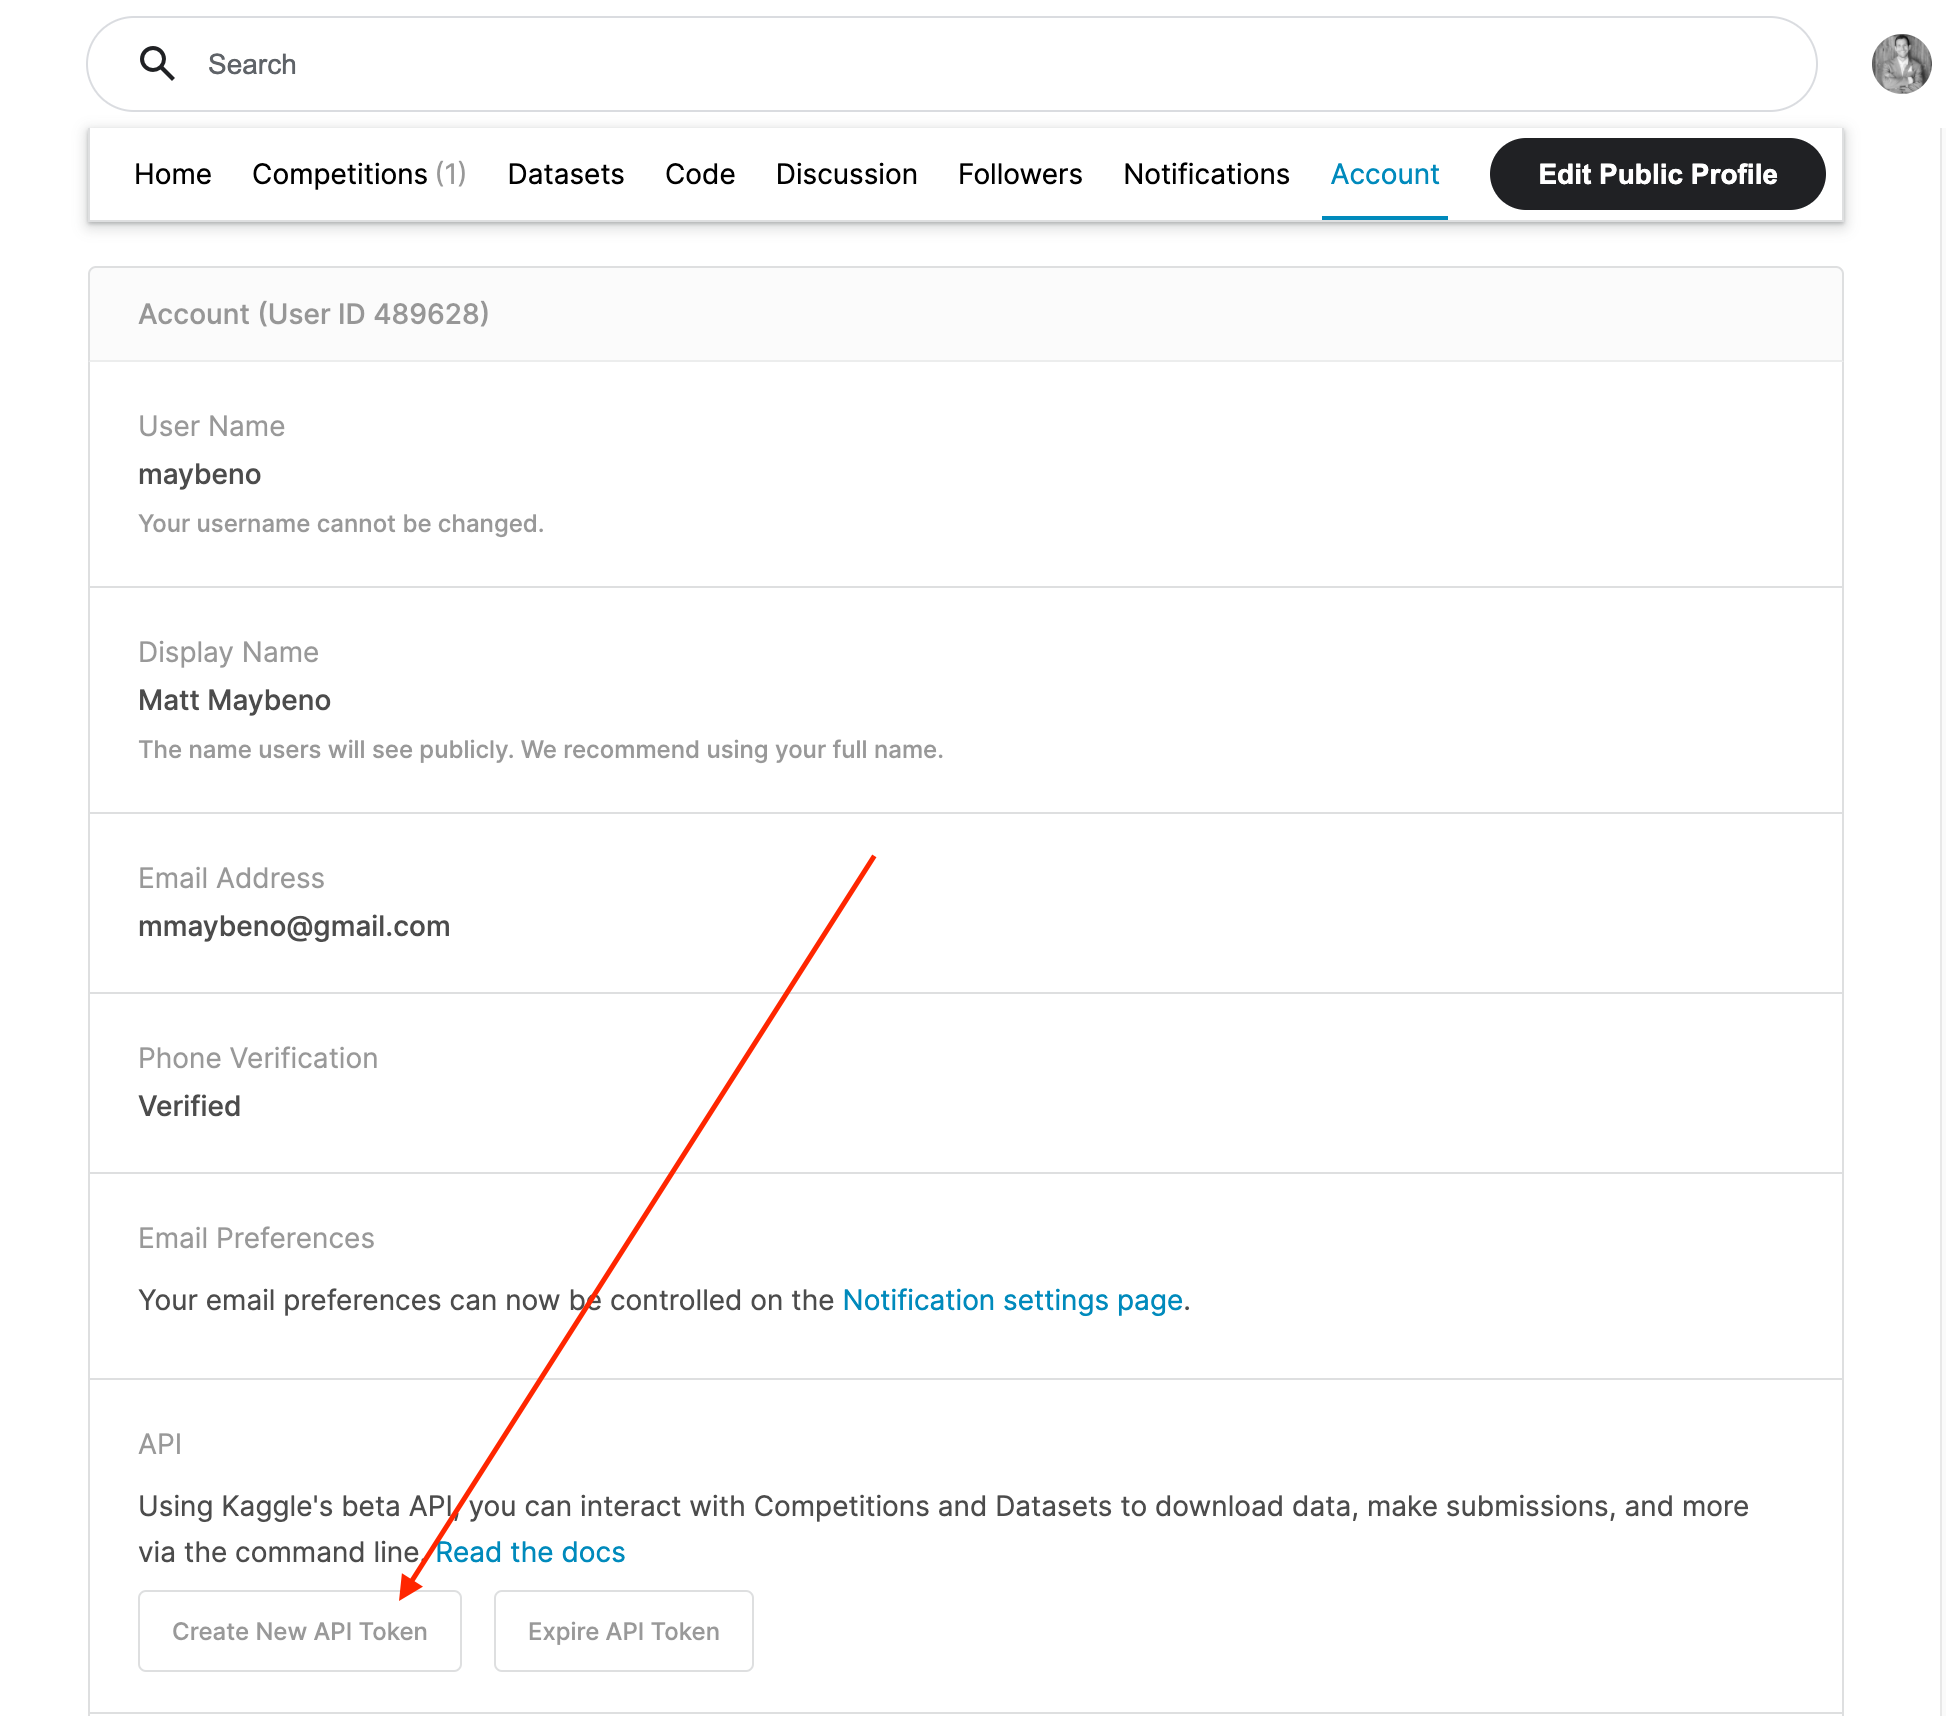
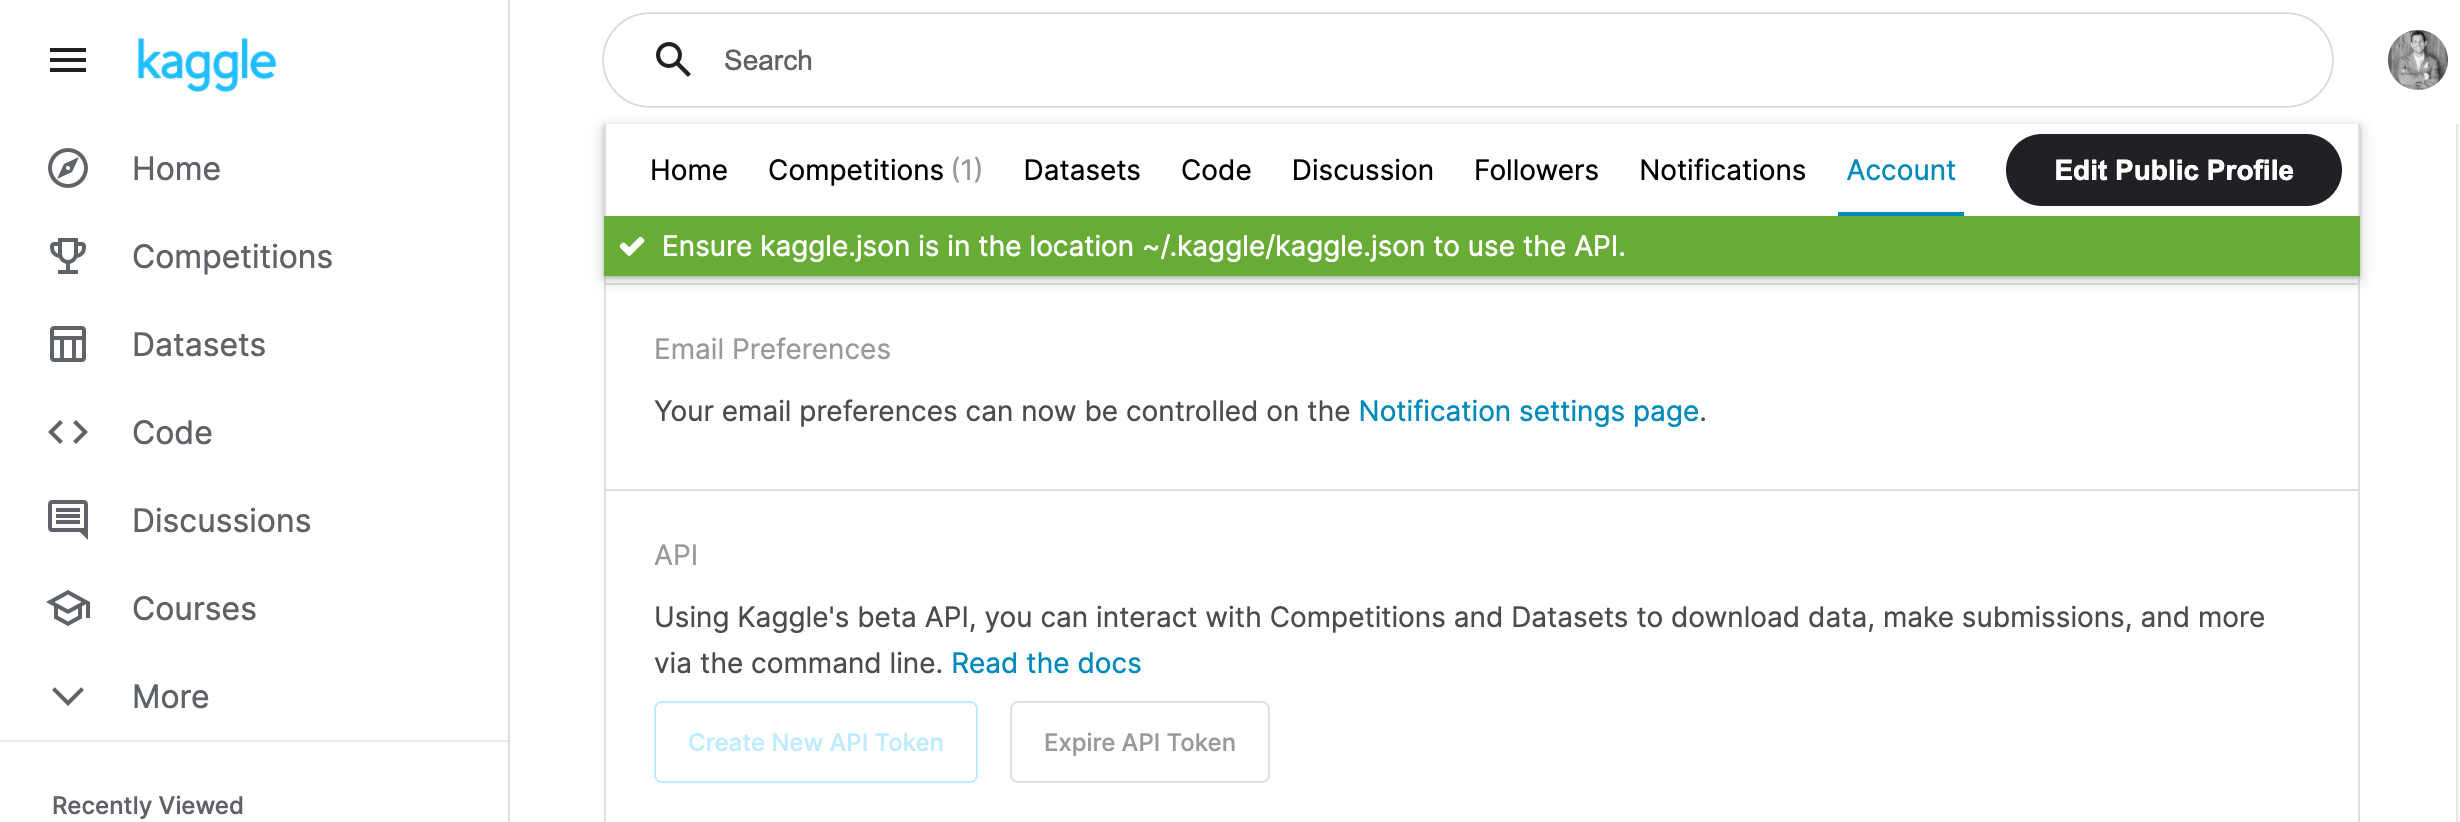
3. Open up `kaggle.json` and use the username and key.
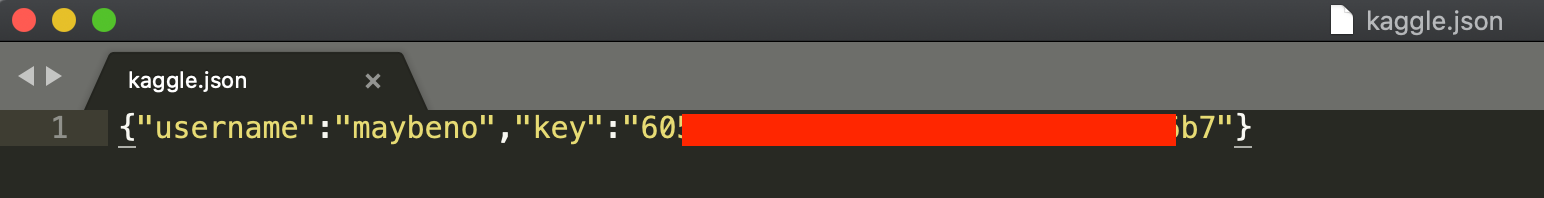

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "wenkaiw"
kaggle_key = "eddec174d85635bcacf025bd9470412"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
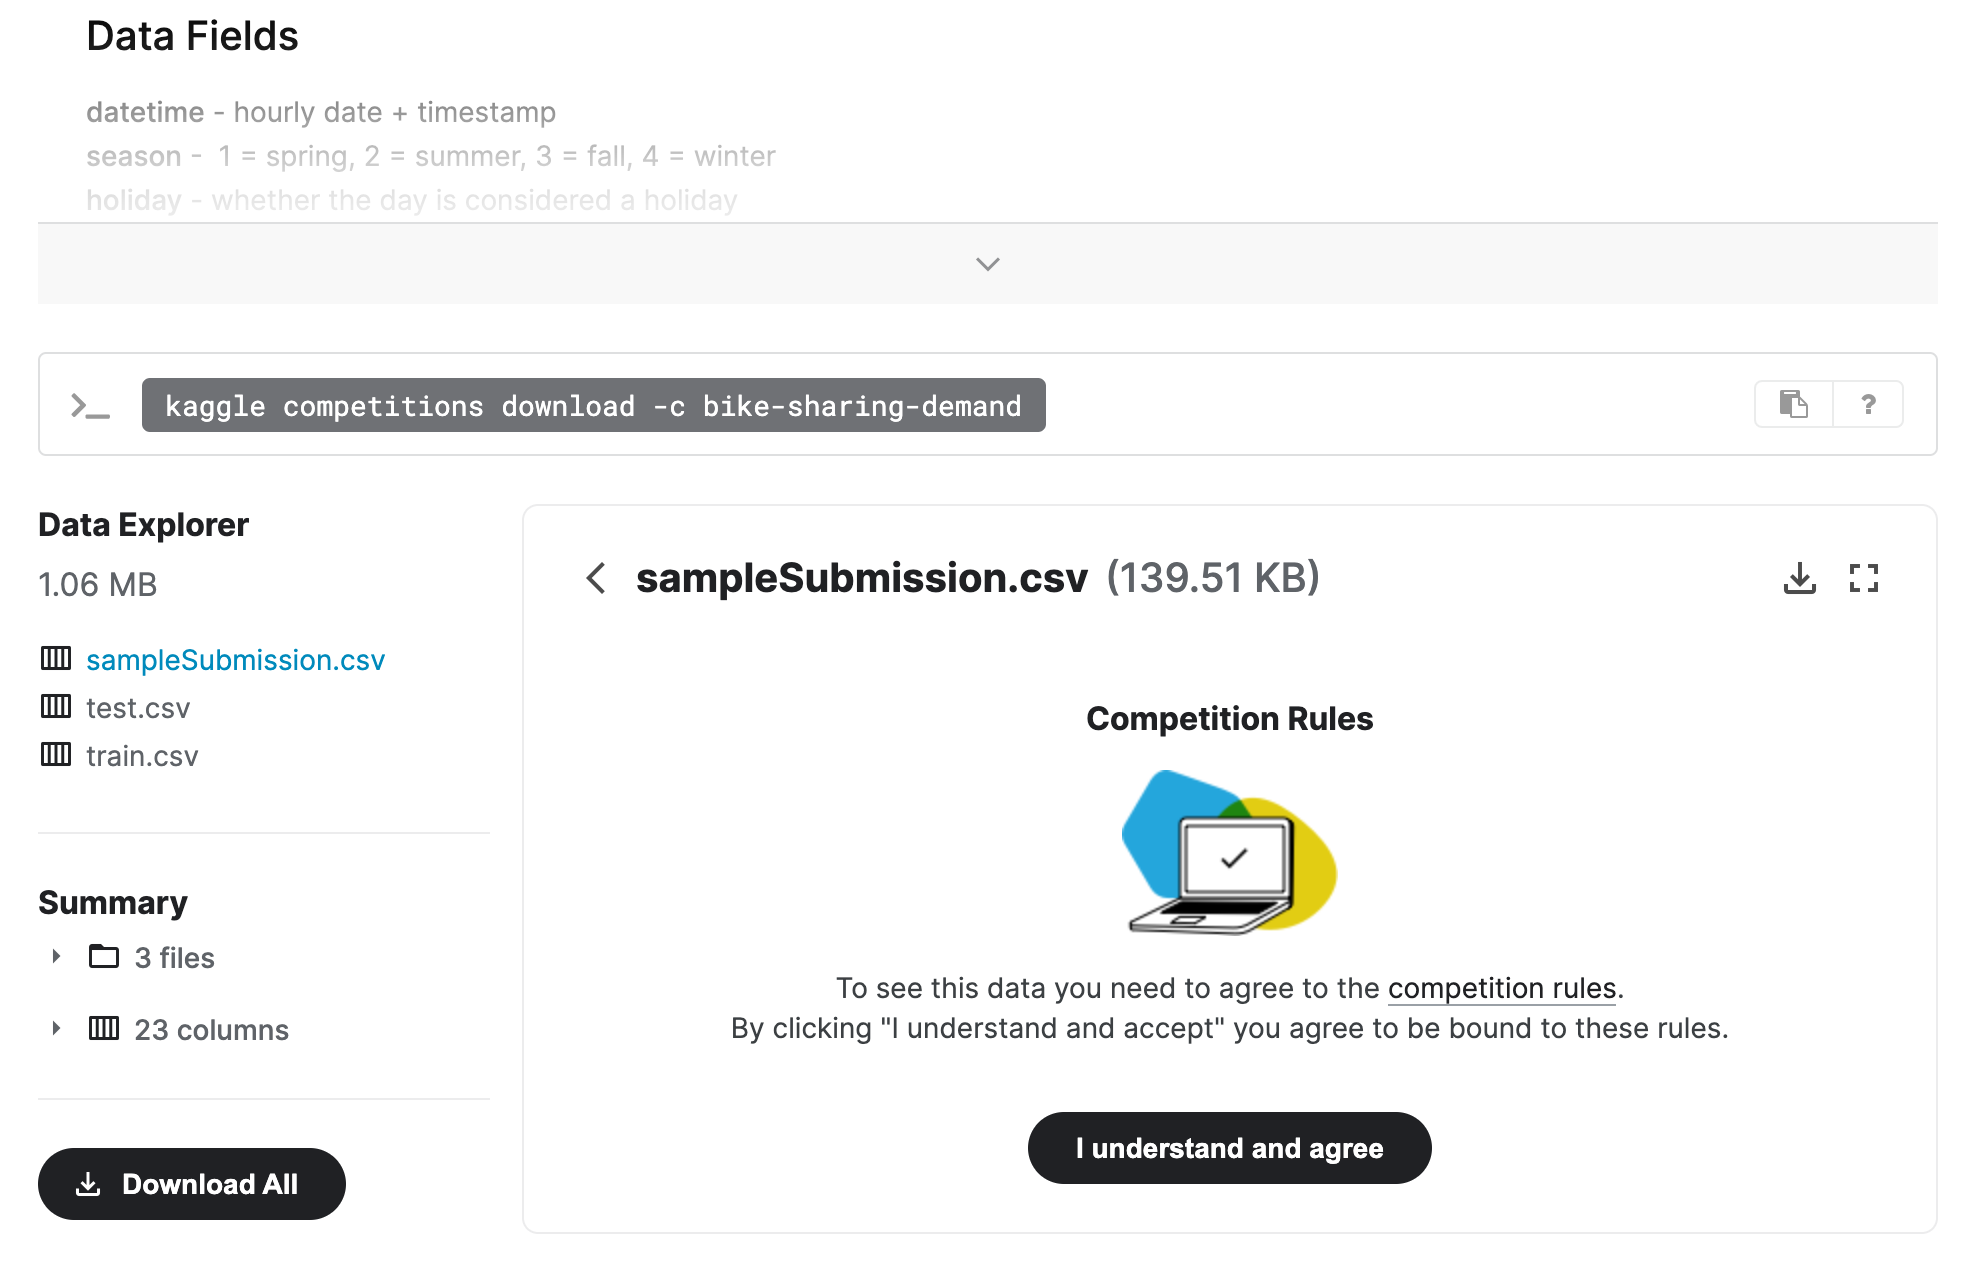

In [1]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
# !kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
# !unzip -o bike-sharing-demand.zip

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from autogluon.tabular import TabularPredictor

In [21]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [4]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [5]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [6]:
# Same thing as train and test dataset
submission = pd.read_csv("data/sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [30]:
predictor = TabularPredictor(
    label="count", 
    problem_type="regression", 
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)
                                                                                          

No path specified. Models will be saved in: "AutogluonModels/ag-20220403_215705/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220403_215705/"
AutoGluon Version:  0.4.0
Python Version:     3.9.7
Operating System:   Darwin
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    391.59 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting 

		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/wenkaiwu/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/wenkaiwu/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 206.41s of remaining time.
	-84.1058	 = Validation score   (root_mean_squared_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 206.26s of the 206.25s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/wenkaiwu/opt/anacond

### Review AutoGluon's training run with ranking of models that did the best.

In [31]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -51.025159       0.771097  451.308120                0.000255           0.119811            3       True         16
1   NeuralNetFastAI_BAG_L2  -52.280977       0.614861  449.583902                0.122451          57.067749            2       True         13
2   RandomForestMSE_BAG_L2  -54.164250       0.570976  393.755368                0.078566           1.239215            2       True         10
3     ExtraTreesMSE_BAG_L2  -54.302187       0.569826  392.881345                0.077416           0.365192            2       True         12
4          CatBoost_BAG_L2  -55.382727       0.515676  424.435747                0.023267          31.919594            2       True         11
5    NeuralNetTorch_BAG_L2  -58.441240       0.644520  502.331243         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.50698580013

<AxesSubplot:xlabel='model'>

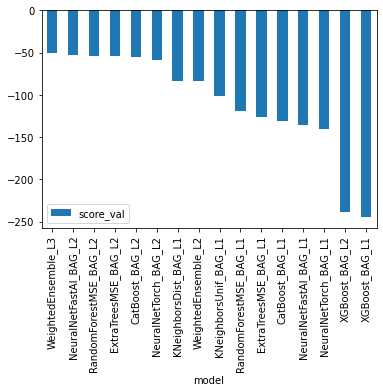

In [32]:
# Output the fit summary of the training run
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Create predictions from test dataset

In [35]:
predictions = predictor.predict(test)
predictions.head()

0    25.395908
1    40.721481
2    46.926262
3    48.073616
4    49.973679
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [36]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean       99.825455
std        88.543869
min         1.512626
25%        20.131336
50%        67.336700
75%       169.070740
max       356.121338
Name: count, dtype: float64

In [38]:
# How many negative values do we have?
predictions.lt(0).sum()

0

In [39]:
# Set them to zero
predictions.clip(lower=0)

0        25.395908
1        40.721481
2        46.926262
3        48.073616
4        49.973679
           ...    
6488    170.985306
6489    170.989395
6490    157.917023
6491    154.561798
6492    148.553497
Name: count, Length: 6493, dtype: float32

### Set predictions to submission dataframe, save, and submit

In [41]:
submission["count"] = predictions
# Round count column values
submission["count"] = submission["count"].apply(lambda x: round(x))
submission.to_csv("submission.csv", index=False)

In [42]:
submission.head()

datetime  count
0 2011-01-20 00:00:00     25
1 2011-01-20 01:00:00     41
2 2011-01-20 02:00:00     47
3 2011-01-20 03:00:00     48
4 2011-01-20 04:00:00     50

In [49]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|████████████████████████████████████████| 148k/148k [00:03<00:00, 47.1kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [50]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-04-03 22:23:11  first raw submission  complete  1.80656      1.80656       


#### Initial score of `1.80656`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

In [7]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

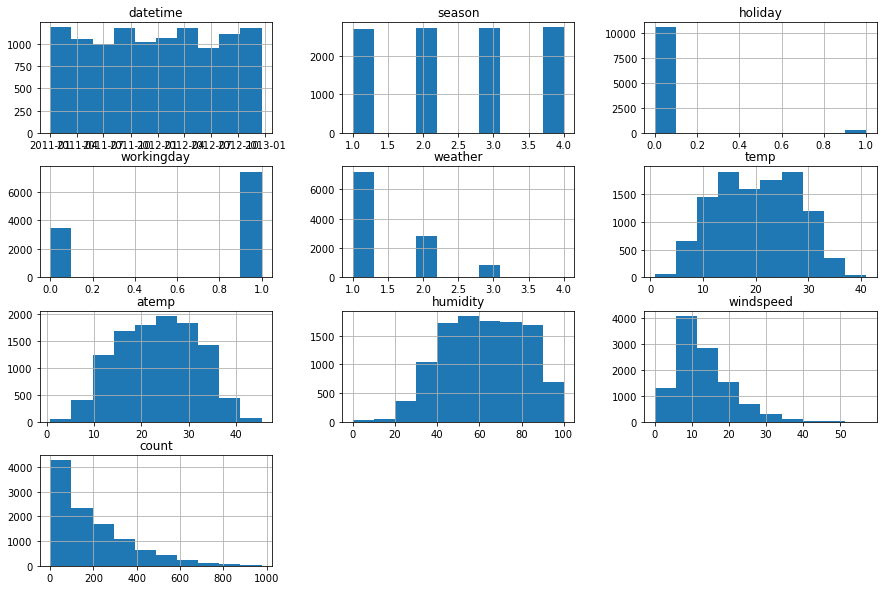

In [22]:
# Create a histogram of all features to show the distribution of each one relative to the data. 
# This is part of the exploritory data analysis
train = train.drop(['casual','registered'], axis=1)
train.hist(figsize=(15, 10));


### Datetime

<AxesSubplot:xlabel='datetime'>

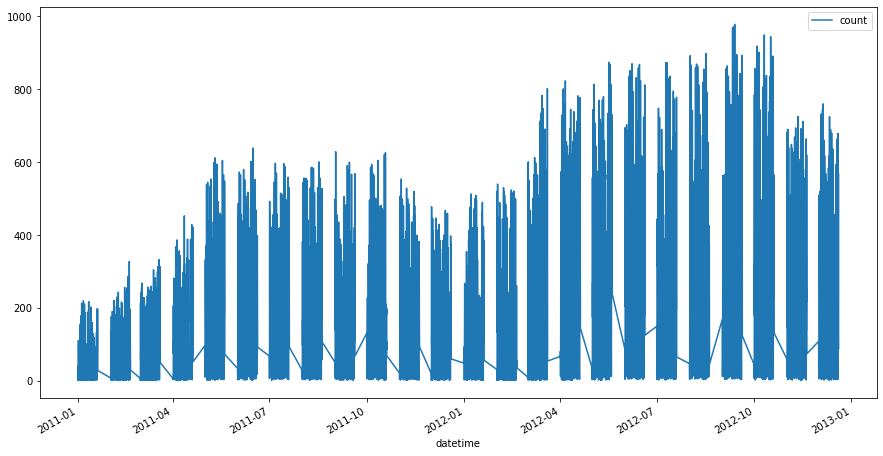

In [23]:
# time series plot for demand
train.plot(x="datetime", y="count", figsize=(15,8))

In [25]:
# separate out the datetime into hour, day, month parts
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["day_of_week"] = train["datetime"].dt.day_of_week
train["hour"] = train["datetime"].dt.time

# add same teatures in test set
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["day_of_week"] = test["datetime"].dt.day_of_week
test["hour"] = test["datetime"].dt.time

train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  count  year  month  day  day_of_week      hour  
0        81        0.0     16  2011      1    1            5  00:00:00  
1        80        0.0     40  2011      1    1            5  01:00:00  
2        80        0.0     32  2011      1    1            5  02:00:00  
3        75        0.0     13  2011      1    1            5  03:00:00  
4        75        0.0      1  2011      1    1            5  04:00:00

<AxesSubplot:xlabel='datetime'>

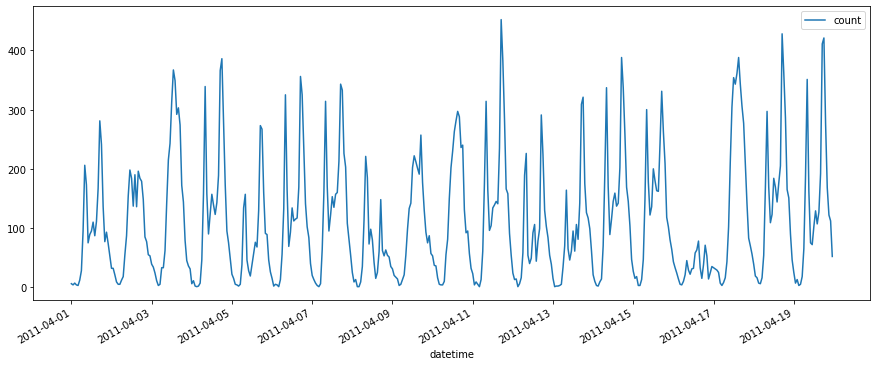

In [30]:
# time series plot for a paticular month: 2011-4
train[ (train["year"]==2011) & (train["month"]==4) ].plot(x="datetime", y="count", figsize=(15,6))

<AxesSubplot:xlabel='datetime'>

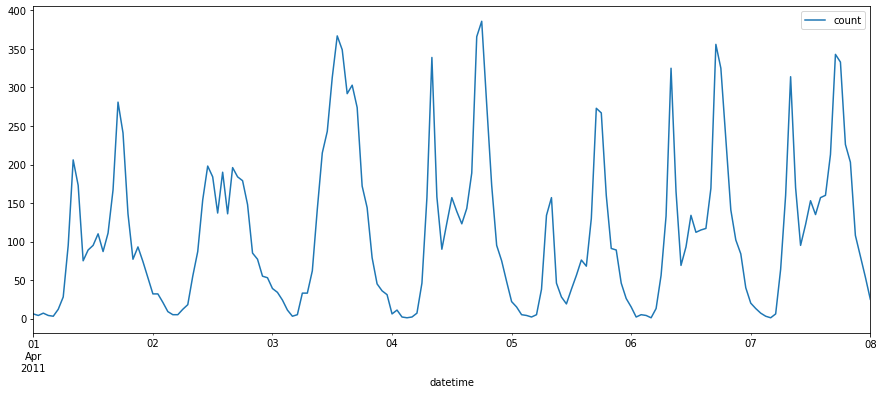

In [29]:
# time series plot for a paticular week: 2011-4-1 - 2011-4-8
train[ 
    (train["datetime"]>='2011-4-1') & 
    (train["datetime"]<='2011-4-8')
].plot(x="datetime", y="count", figsize=(15,6))

### Hour

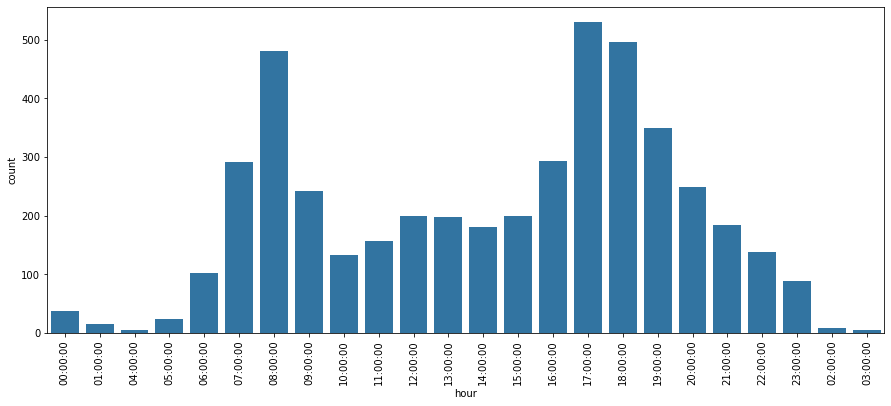

In [47]:
# plot for all working days
plt.figure(figsize=(15,6))
sns.barplot(x="hour",y="count",data=train[train["workingday"]==1], color=sns.color_palette()[0], ci=None)
plt.xticks(rotation = 90);

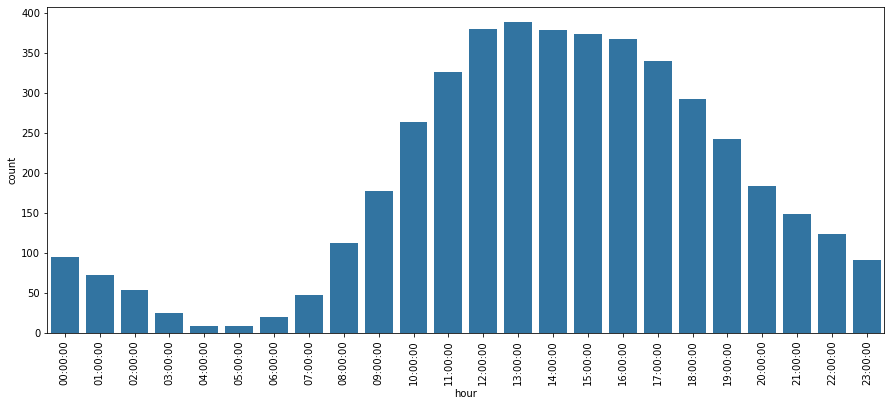

In [48]:
# plot for all weekend
plt.figure(figsize=(15,6))
sns.barplot(x="hour",y="count",data=train[train["workingday"]==0], color=sns.color_palette()[0], ci=None)
plt.xticks(rotation = 90);

In [ ]:
# create new feature for hour: 
def get_time_of_day(hour):
    if hour


### Temprature

In [54]:
# compute the correlation between "temp" and "atemp"
train[["temp", "atemp"]].corr()

temp     atemp
temp   1.000000  0.984948
atemp  0.984948  1.000000

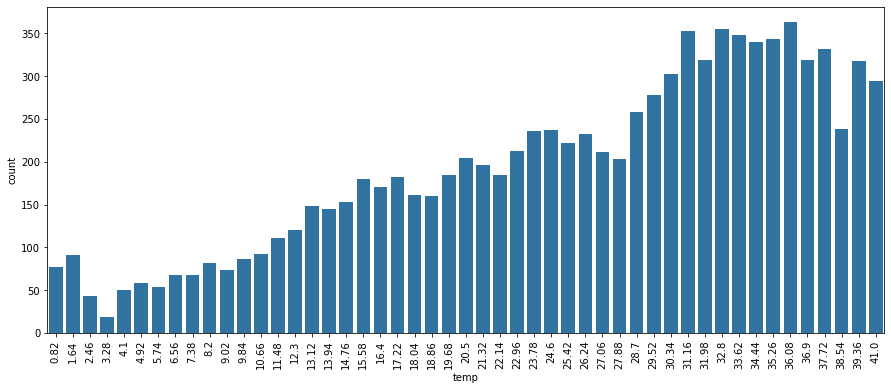

In [58]:
# we choose temp rather than atemp becasue the distribution "feel-like" temp has more bias
# plot for temp
plt.figure(figsize=(15,6))
sns.barplot(x="temp",y="count", data=train, color=sns.color_palette()[0], ci=None)
plt.xticks(rotation = 90);

In [60]:
# create new feature: temp_category
def get_temp_category(temp):
    if temp <= 13:
        return 0 # low temp
    elif (temp > 13) and (temp <= 28 ):
        return 1 # mild temp
    elif (temp > 28):
        return 2 # hot temp

train['temp_category'] = train['temp'].apply(get_temp_category)
test['temp_category'] = test['temp'].apply(get_temp_category)

### Humidity

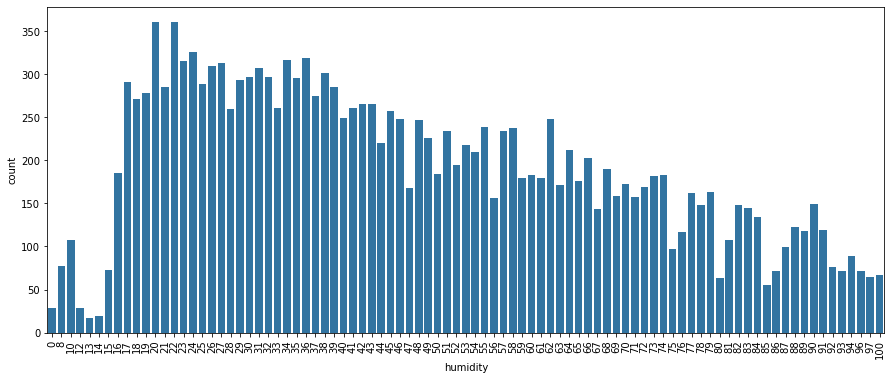

In [61]:
# plot for humidity
plt.figure(figsize=(15,6))
sns.barplot(x="humidity", y="count", data=train, color=sns.color_palette()[0], ci=None)
plt.xticks(rotation = 90);

In [79]:
# create new feature: humidity_category
def get_humid_category(humid):
    if humid <= 15:
        return 0 # low temp
    elif (humid > 15) and (humid <= 46 ):
        return 1 # mild temp
    elif (humid > 46) and (humid < 75 ):
        return 2 # hot temp
    else:
        return 3

train['humid_category'] = train['humidity'].apply(get_humid_category)
test['humid_category'] = test['humidity'].apply(get_humid_category)

/var/folders/cw/qph5p4hs3xq46rn9lkw59nr80000gn/T/ipykernel_76665/3011053929.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['humid_category'] = train['humidity'].apply(get_humid_category)


### Windspeed

<AxesSubplot:ylabel='windspeed'>

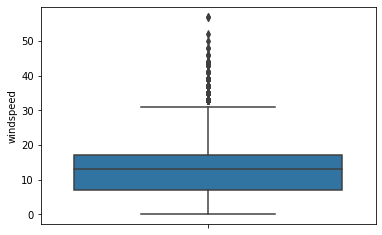

In [71]:
# the distribution of windspeed shows there are outliers
sns.boxplot(data=train, y="windspeed",orient="v")

In [74]:
train = train[train["windspeed"]-train["windspeed"].mean() <=(3*train["windspeed"].std())]

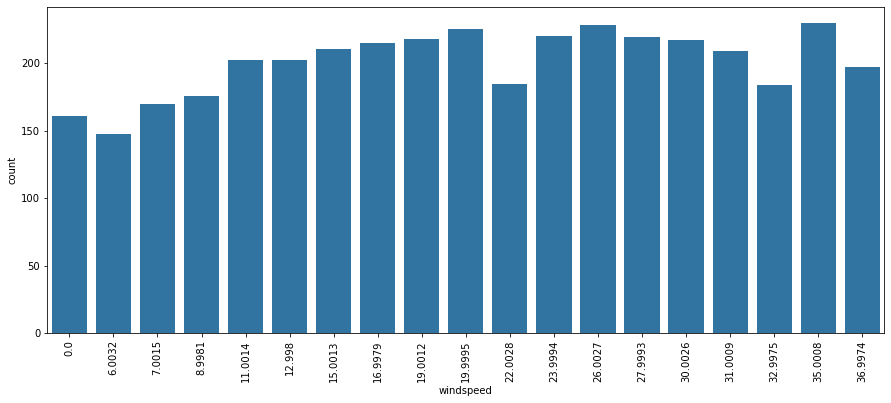

In [75]:
# plot for windspeed
plt.figure(figsize=(15,6))
sns.barplot(x="windspeed", y="count", data=train, color=sns.color_palette()[0], ci=None)
plt.xticks(rotation = 90);

In [78]:
# create new feature: wind_category
def get_wind_category(wind):
    if wind <= 10:
        return 0 # low wind
    elif (wind > 10) and (wind <= 20 ):
        return 1 # mild wind
    elif (wind > 20):
        return 2 # high temp

train['wind_category'] = train['windspeed'].apply(get_wind_category)
test['wind_category'] = test['windspeed'].apply(get_wind_category)

/var/folders/cw/qph5p4hs3xq46rn9lkw59nr80000gn/T/ipykernel_76665/3089779917.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wind_category'] = train['windspeed'].apply(get_wind_category)


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
train["season"] = ?
train["weather"] = ?
test["season"] = ?
test["weather"] = ?

In [ ]:
# View are new feature
train.head()

In [ ]:
# View histogram of all features again now with the hour feature
train.?

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(
    label="count", 
    problem_type="regression", 
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)
   

In [ ]:
predictor_new_features.fit_summary()

In [ ]:
# Remember to set all negative values to zero
?

In [ ]:
# Same submitting predictions
submission_new_features["count"] = ?
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
predictor_new_hpo = TabularPredictor(?).fit(?)

In [ ]:
predictor_new_hpo.fit_summary()

In [ ]:
# Remember to set all negative values to zero
?

In [ ]:
# Same submitting predictions
submission_new_hpo["count"] = ?
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [?, ?, ?],
    "hpo2": [?, ?, ?],
    "hpo3": [?, ?, ?],
    "score": [?, ?, ?]
})